<a href="https://colab.research.google.com/github/Hab-eeb/08-weather-conditions/blob/master/model/VECM_Temperature_forecasting_model_for_APAPA_LAGOS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
df_station = pd.read_csv('https://raw.githubusercontent.com/HamoyeHQ/08-weather-conditions/master/data/Cleanedstationlocation.csv')
df_station.head()

,WBAN,NAME,STATE/COUNTRY ID,LAT,LON,ELEV,Latitude,Longitude
0,33013,AIN EL,AL,3623N,00637E,611,36.383333,6.650000
1,33031,LA SENIA,AL,3537N,00037E,88,35.616667,0.583333
2,33023,MAISON BLANCHE,AL,3643N,00314E,23,36.716667,3.216667
3,33044,TELERGMA,AL,3607N,00621E,754,36.116667,6.416667
4,12001,TINDOUF,AL,2741N,00809W,443,27.683333,-8.083333


In [4]:
df_weather = pd.read_csv('https://raw.githubusercontent.com/HamoyeHQ/08-weather-conditions/master/data/Cleanedweathersummary.csv')
df_weather.head()

,STA,Date,Precip,MaxTemp,MinTemp,MeanTemp,Snowfall,PoorWeather,YR,MO,DA
0,10001,1942-07-01,1,25,22,23,0,0,42,7,1
1,10001,1942-07-02,0,28,21,25,0,0,42,7,2
2,10001,1942-07-03,2,26,22,24,0,0,42,7,3
3,10001,1942-07-04,2,26,22,24,0,0,42,7,4
4,10001,1942-07-05,0,26,21,24,0,0,42,7,5


In [5]:
df_weather.drop(['YR','MO','DA'], axis=1,inplace = True)

In [6]:
from datetime import datetime
df_weather['datetime'] = pd.to_datetime(df_weather['Date'])
# setting STA as the index to select APAPA weather station 
df_weather = df_weather.set_index('STA')
df_weather.drop(['Date'], axis=1, inplace=True)
df_weather.head()

,Precip,MaxTemp,MinTemp,MeanTemp,Snowfall,PoorWeather,datetime
STA,,,,,,,
10001,1,25,22,23,0,0,1942-07-01
10001,0,28,21,25,0,0,1942-07-02
10001,2,26,22,24,0,0,1942-07-03
10001,2,26,22,24,0,0,1942-07-04
10001,0,26,21,24,0,0,1942-07-05


In [7]:
df_weather = df_weather.loc['30001']
df_weather = df_weather.set_index('datetime')
df_weather.head()

,Precip,MaxTemp,MinTemp,MeanTemp,Snowfall,PoorWeather
datetime,,,,,,
1943-06-09,23,28,22,25,0,1
1943-06-10,19,27,20,23,0,1
1943-06-11,0,28,21,24,0,1
1943-06-12,0,28,22,25,0,1
1943-06-13,0,29,25,27,0,1


In [8]:
df_weather.drop(['Snowfall','PoorWeather','Precip'], axis=1,inplace = True)

In [9]:
# save to file
df_weather.to_csv('weather.csv')

In [10]:
df_weather.describe()

,MaxTemp,MinTemp,MeanTemp
count,522.000000,522.000000,522.000000
mean,28.490421,22.662835,25.561303
std,1.771199,1.540658,1.353561
min,23.000000,16.000000,22.000000
25%,27.000000,22.000000,25.000000
50%,28.000000,22.000000,25.000000
75%,30.000000,23.000000,26.000000
max,32.000000,28.000000,30.000000


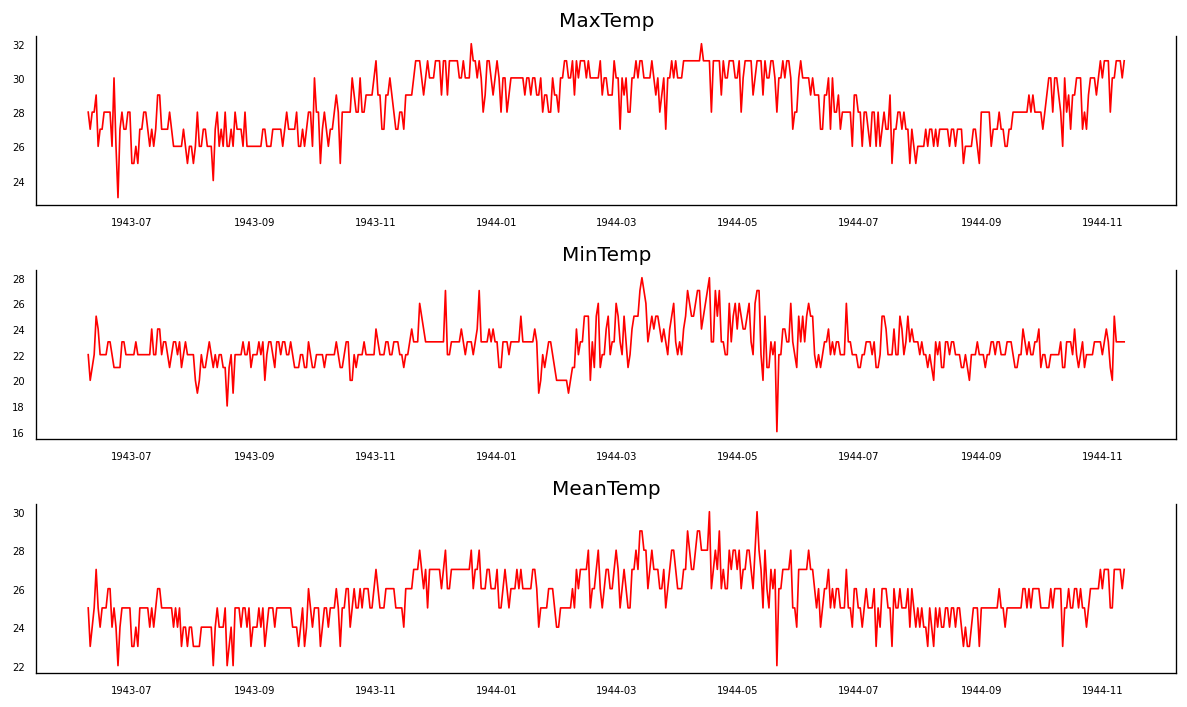

In [11]:
#Visualize the Time Series
# Plot
fig, axes = plt.subplots(nrows=3, ncols=1, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df_weather[df_weather.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df_weather.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [12]:
# Split the Series into Training and Testing Data, I will hold back the last 7 days
n_obs = 7
X_train, X_test = df_weather[0:-n_obs], df_weather[-n_obs:]
# Check size
print(X_train.shape)
print(X_test.shape)

(515, 3)
(7, 3)


## Testing Causation using Granger’s Causality Test
The basis behind Vector AutoRegression is that each of the time series in the system influences each other. That is, you can predict the series with past values of itself along with other series in the system.

Using Granger’s Causality Test, it’s possible to test this relationship before even building the model.


Granger’s causality tests the null hypothesis that the coefficients of past values in the regression equation is zero.

In simpler terms, the past values of time series (X) do not cause the other series (Y). So, if the p-value obtained from the test is lesser than the significance level of 0.05, then, you can safely reject the null hypothesis.

In [13]:
# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
model = VAR(df_weather)
x = model.select_order(maxlags=12)
x.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


,AIC,BIC,FPE,HQIC
0,-0.1262,-0.1013,0.8815,-0.1164
1,-1.181,-1.082,0.3068,-1.142
2,-1.275,-1.101*,0.2794,-1.207
3,-1.314,-1.065,0.2688,-1.216*
4,-1.342,-1.019,0.2612,-1.215
5,-1.353,-0.9549,0.2584,-1.197
6,-1.352,-0.8788,0.2587,-1.167
7,-1.354*,-0.8063,0.2582*,-1.139
8,-1.351,-0.7288,0.2589,-1.107
9,-1.338,-0.6410,0.2623,-1.065



I have implemented Akaike’s Information Criteria (AIC) through the VAR (p) to determine the lag order value. 

In [14]:
#https://stackoverflow.com/questions/43443856/simple-granger-casuality-test-using-statsmodels-tsa-grangercausalitytests
from statsmodels.tsa.stattools import grangercausalitytests
maxlag= 7

test = 'ssr-chi2test'

def grangers_causality_matrix(data, variables, test = 'ssr_chi2test', verbose=False):

    dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)

    for c in dataset.columns:
        for r in dataset.index:
            test_result = grangercausalitytests(data[[r,c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')

            min_p_value = np.min(p_values)
            dataset.loc[r,c] = min_p_value

    dataset.columns = [var + '_x' for var in variables]

    dataset.index = [var + '_y' for var in variables]

    return dataset

grangers_causality_matrix(df_weather, variables = df_weather.columns)

,MaxTemp_x,MinTemp_x,MeanTemp_x
MaxTemp_y,1.0,0.3625,0.1008
MinTemp_y,0.0,1.0000,0.0000
MeanTemp_y,0.0,0.0009,1.0000


# VECM modelling 


> VECM imposes additional restriction due to the existence of non-stationary but co-integrated data forms. It utilizes the co-integration restriction information into its specifications. After the cointegration is known then the next test process is done by using error correction method. 



In [15]:
from statsmodels.tsa.vector_ar import vecm

vec_rank_1 = vecm.select_coint_rank(X_train, det_order=-1,k_ar_diff=8,method="trace",signif=0.01)
print(vec_rank_1.summary())


Johansen cointegration test using trace test statistic with 1% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   3          59.34          29.51
  1   3          17.57          16.36
  2   3         0.1394          6.941
-------------------------------------


In [16]:
vec_rank_2 = vecm.select_coint_rank(X_train, det_order=-1,k_ar_diff=1,method="maxeig",signif=0.01)
print(vec_rank_2.summary())

Johansen cointegration test using maximum eigenvalue test statistic with 1% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   1          176.9          22.25
  1   2          101.5          15.09
  2   3        0.03214          6.941
-------------------------------------


In [17]:
coint_check = vecm.coint_johansen(X_train,-1,1)
print(coint_check.eig)

[2.91728139e-01 1.79475247e-01 6.26537140e-05]


From the above code it can be said that the three columns are co-integrated because none of them have eig values above 1 

In [18]:
model_vecm = vecm.VECM(X_train,k_ar_diff=8,coint_rank=3)
vecm_fit =model_vecm.fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [19]:
forecast,lower,upper = vecm_fit.predict(7,0.05)
print("lower bounds of confidence intervals:")
print(lower.round(3))
print("\npoint forecasts:")
print(forecast.round(3))
print("\nupper bounds of confidence intervals:")
print(upper.round(3))

lower bounds of confidence intervals:
[[27.643 19.671 24.044]
 [28.065 20.361 24.593]
 [27.976 20.467 24.568]
 [27.857 20.239 24.612]
 [27.794 19.945 24.354]
 [28.327 20.443 24.851]
 [27.967 20.505 24.663]]

point forecasts:
[[29.594 22.065 25.756]
 [30.111 22.969 26.42 ]
 [30.061 23.126 26.443]
 [29.977 22.918 26.512]
 [29.95  22.656 26.278]
 [30.518 23.25  26.828]
 [30.186 23.331 26.656]]

upper bounds of confidence intervals:
[[31.546 24.459 27.467]
 [32.157 25.578 28.247]
 [32.145 25.786 28.318]
 [32.097 25.596 28.413]
 [32.105 25.368 28.202]
 [32.709 26.058 28.804]
 [32.405 26.157 28.648]]


In [20]:
#Converting the forecast into a Dataframe for easy manipulation
forecast_df = forecast.copy()
forecast_df= pd.DataFrame(forecast_df,columns=["MaxTemp","MinTemp","MeanTemp"])
forecast_df.set_index(X_test.index,inplace=True)
forecast_df

,MaxTemp,MinTemp,MeanTemp
datetime,,,
1944-11-06,29.594388,22.065338,25.755516
1944-11-07,30.111171,22.969314,26.419967
1944-11-08,30.060852,23.126216,26.442932
1944-11-09,29.977073,22.917776,26.512157
1944-11-10,29.949514,22.656045,26.278131
1944-11-11,30.518077,23.250414,26.827559
1944-11-12,30.185974,23.330925,26.655663


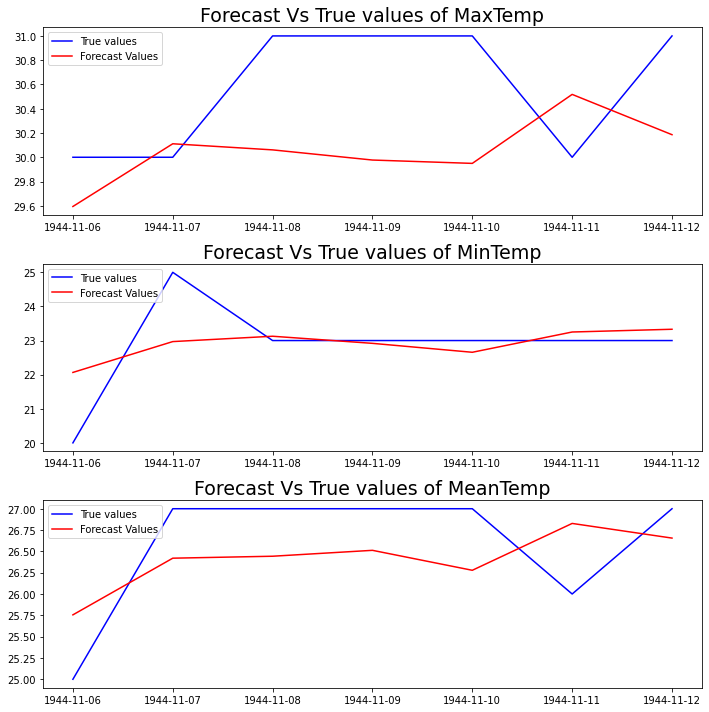

In [25]:
fig, axes = plt.subplots(nrows=3,figsize=(10,10))
for i,ax in enumerate(axes.flatten()):
  data1= X_test[X_test.columns[i]]
  data2= forecast_df[forecast_df.columns[i]]
  ax.plot(data1,color="blue",label="True values")
  ax.plot(data2,color="red",label="Forecast Values")
  fontdict={"fontsize":19}
  ax.set_title("Forecast Vs True values of "+ X_test.columns[i],fontdict=fontdict)
  ax.legend(loc=2)

plt.tight_layout()

In [22]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual)) *100  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

In [23]:
print('Forecast Accuracy of: MaxTemp')
accuracy_prod = forecast_accuracy(forecast_df['MaxTemp'].values, X_test['MaxTemp'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))
print('Forecast Accuracy of: MinTemp')
accuracy_prod = forecast_accuracy(forecast_df['MinTemp'].values, X_test['MinTemp'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))
print('Forecast Accuracy of: MeanTemp')
accuracy_prod = forecast_accuracy(forecast_df['MeanTemp'].values, X_test['MeanTemp'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

Forecast Accuracy of: MaxTemp
mape :  2.2562
me :  -0.5147
mae :  0.6945
mpe :  -0.0166
rmse :  0.769
corr :  -0.0599
minmax :  0.0225
Forecast Accuracy of: MinTemp
mape :  3.3398
me :  0.0451
mae :  0.7471
mpe :  0.0049
rmse :  1.115
corr :  0.6967
minmax :  0.032
Forecast Accuracy of: MeanTemp
mape :  2.3103
me :  -0.1583
mae :  0.6106
mpe :  -0.0054
rmse :  0.6302
corr :  0.5619
minmax :  0.0228


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if sys.path[0] == '':
